## Задание

- Попробуйте применить метод Монте-Карло с разделенной стратегией для среды `LunarLander` из библиотеки OpenAI Gym.
- Проанализируйте, как изменяется Q-функция и стратегия в процессе обучения для новой среды.

In [1]:
#@title Установка зависимостей
!apt update -y
!apt install -y swig build-essential python3-dev >/dev/null

# Gymnasium c box2d, плюс numpy и torch, matplotlib
!pip install -q gymnasium[box2d] numpy torch matplotlib

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,839 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,498 kB]
Fetched 12.3 MB in 3s (3,620 kB/s)
Reading package lists... Don

In [2]:
#@title Импорты
import gymnasium as gym
import numpy as np
import torch
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import time
import math

# совместимость numpy/gym
np.bool8 = np.bool_

In [3]:
#@title Константы, сидирование и инициализация среды
ENV_ID = "LunarLander-v3"
SEED = 42

# Дискретная версия среды (4 действия: 0 - noop, 1 - left, 2 - main, 3 - right)
env = gym.make(ENV_ID, continuous=False, gravity=-10.0, enable_wind=False)
env.reset(seed=SEED)

# Параметры обучения
GAMMA = 0.99  # Коэффициент обесценивания
N_EPISODE = 100000  # Количество эпизодов обучения
MAX_STEPS = 500  # Ограничение длины эпизода для контроля дисперсии

# Параметры для ε-soft поведенческой стратегии
EPS_START = 0.9  # Начальное значение epsilon (больше exploration в начале)
EPS_FINAL = 0.1  # Финальное значение epsilon (меньше exploration в конце)
EPS_DECAY_EPISODES = 25000  # Количество эпизодов для уменьшения epsilon



N_ACTION = env.action_space.n
obs_shape = env.observation_space.shape


In [4]:
#@title Дискретизация пространства состояний

# Границы наблюдений из официального описания среды LunarLander
OBS_LOW = np.array([-2.5, -2.5, -10.0, -10.0, -6.2831855, -10.0, 0.0, 0.0], dtype=np.float32)
OBS_HIGH = np.array([ 2.5,  2.5,  10.0,  10.0,  6.2831855,  10.0, 1.0, 1.0], dtype=np.float32)

# Количество бинов для каждого измерения состояния
# Угол (5-е измерение) детализируем сильнее для лучшего разрешения
NUM_BINS = (5, 5, 5, 5, 7, 5, 2, 2)

# Создание границ бинов для первых 6 непрерывных измерений
BIN_EDGES = []
for i in range(6):
    edges = np.linspace(OBS_LOW[i], OBS_HIGH[i], NUM_BINS[i]-1)
    BIN_EDGES.append(edges)

def discretize_state(state):
    """
    Преобразует непрерывное состояние в дискретное представление.
    """
    discrete = []
    # Дискретизация первых 6 непрерывных измерений
    for i in range(6):
        val = float(np.clip(state[i], OBS_LOW[i], OBS_HIGH[i]))
        idx = int(np.digitize(val, BIN_EDGES[i]))
        idx = max(0, min(NUM_BINS[i] - 1, idx))
        discrete.append(idx)
    # Последние 2 измерения (контакты ног) - бинарные значения
    discrete.append(int(bool(state[6])))
    discrete.append(int(bool(state[7])))
    return tuple(discrete)

In [5]:
#@title Поведенческая стратегия (ε-soft с уменьшением epsilon)

class EpsilonSoftPolicy:
    """
    ε-soft поведенческая стратегия для off-policy MC control.
    """
    def __init__(self, n_action, eps_start, eps_final, eps_decay_episodes):
        """
        Инициализация ε-soft политики.
        """
        self.n_action = n_action
        self.eps_start = eps_start
        self.eps_final = eps_final
        self.eps_decay_episodes = eps_decay_episodes

    def get_epsilon(self, episode):
        """
        Вычисляет текущее значение epsilon для данного эпизода.
        """
        if self.eps_decay_episodes == 0:
            return self.eps_final
        frac = min(1.0, episode / self.eps_decay_episodes)
        return self.eps_start + (self.eps_final - self.eps_start) * frac

    def __call__(self, state, Q, episode):
        """
        Возвращает вероятности действий для данного состояния.
        """
        epsilon = self.get_epsilon(episode)

        # Базовое равномерное распределение
        probs = torch.ones(self.n_action, dtype=torch.float32) * (epsilon / self.n_action)

        # Если Q уже инициализирован для этого состояния, добавляем вес жадному действию
        if state in Q:
            q_vals = Q[state]
            if torch.any(torch.isfinite(q_vals)):
                best_action = torch.argmax(q_vals).item()
                probs[best_action] += (1.0 - epsilon)

        return probs

# Создание ε-soft поведенческой стратегии с уменьшением epsilon
behavior_policy = EpsilonSoftPolicy(env.action_space.n, EPS_START, EPS_FINAL, EPS_DECAY_EPISODES)

In [6]:
#@title Запуск эпизода

def run_episode(env, behavior_policy, state_discretizer, Q, episode, max_steps=MAX_STEPS):
    """
    Выполняет один эпизод, следуя заданной поведенческой стратегии.
    """
    state, _ = env.reset()
    rewards = []
    actions = []
    states = []

    steps = 0
    while True:
        dstate = state_discretizer(state)
        # Для ε-soft стратегии передаем Q-функцию и номер эпизода
        probs = behavior_policy(dstate, Q, episode)
        action = torch.multinomial(probs, 1).item()

        actions.append(action)
        states.append(dstate)

        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(float(reward))

        steps += 1
        if terminated or truncated or steps >= max_steps:
            break

    return states, actions, rewards

In [7]:
#@title MC control off-policy (с разделенной стратегией)
def mc_control_off_policy(env, gamma, n_episode, behavior_policy, state_discretizer, verbose=True):
    """
    Строит оптимальную стратегию методом управления МК с разделенной стратегией.

    Отслеживает изменения Q-функции и стратегии в процессе обучения для анализа.
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(float)
    Q = defaultdict(lambda: torch.zeros(n_action, dtype=torch.float32))

    returns = []  # История наград за эпизоды

    # История изменений Q-функции и стратегии для анализа
    q_history = {
        'episodes': [],
        'max_q': [],
        'min_q': [],
        'avg_q': [],
        'num_states': []
    }

    policy_history = {
        'episodes': [],
        'policy_changes': [],
        'num_states': []
    }

    prev_policy = {}

    for episode in range(n_episode):
        w = 1.0
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy, state_discretizer, Q, episode)
        return_t = 0.0
        G = {}

        # Обратный проход по эпизоду для вычисления возвратов и веса W
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t

            # Если действие не соответствует наилучшему действию по Q-функции, прерываем цикл
            if action_t != torch.argmax(Q[state_t]).item():
                break

            # Обновление веса W
            b_prob = float(behavior_policy(state_t, Q, episode)[action_t].item())
            w *= 1.0 / b_prob

        # Обновление Q-функции на основе возвратов и весов W
        for state_action, return_t in G.items():
            state, action = state_action
            G_sum[state_action] += return_t * w
            N[state_action] += w
            if N[state_action] > 0:
                Q[state][action] = G_sum[state_action] / N[state_action]

        # Логирование
        ep_return = sum(rewards_t)
        returns.append(ep_return)
        avg_return_recent = (
            np.mean(returns[-100:]) if len(returns) >= 100 else np.mean(returns)
        )

        # Отслеживание изменений Q-функции и стратегии для анализа
        track_interval = max(1, n_episode // 50)
        if episode % track_interval == 0 or episode == 0 or episode == n_episode - 1:
            q_values_all = []
            for s in Q:
                q_vals = Q[s]
                finite_vals = q_vals[torch.isfinite(q_vals)]
                if len(finite_vals) > 0:
                    q_values_all.extend(finite_vals.tolist())

            max_q = max(q_values_all) if len(q_values_all) > 0 else 0.0
            min_q = min(q_values_all) if len(q_values_all) > 0 else 0.0
            avg_q = np.mean(q_values_all) if len(q_values_all) > 0 else 0.0

            q_history['episodes'].append(episode)
            q_history['max_q'].append(max_q)
            q_history['min_q'].append(min_q)
            q_history['avg_q'].append(avg_q)
            q_history['num_states'].append(len(Q))

            current_policy = {}
            for state, actions in Q.items():
                current_policy[state] = torch.argmax(actions).item()

            policy_changes = 0
            for state in current_policy:
                if state in prev_policy:
                    if current_policy[state] != prev_policy[state]:
                        policy_changes += 1
                else:
                    policy_changes += 1

            policy_history['episodes'].append(episode)
            policy_history['policy_changes'].append(policy_changes)
            policy_history['num_states'].append(len(current_policy))

            prev_policy = current_policy.copy()

        # Вывод информации о прогрессе
        if verbose and episode % (n_episode // 10) == 0:
            print(f"EP {episode+1}/{n_episode}, avg_return_recent={avg_return_recent:.2f}")

    # Формирование оптимальной стратегии на основе Q-функции
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()

    return Q, policy, returns, q_history, policy_history

In [8]:
#@title Запуск обучения
start_time = time.time()
Q_optimal, optimal_policy, returns, q_history, policy_history = mc_control_off_policy(
    env,
    GAMMA,
    N_EPISODE,
    behavior_policy,
    discretize_state,
    verbose=True
)
elapsed = time.time() - start_time

print(f"\nОбучение завершено за {elapsed:.1f} сек.")
print(f"Средняя награда Off-Policy: {np.mean(returns[-100:]):.2f}")

EP 1/100000, avg_return_recent=-284.15
EP 10001/100000, avg_return_recent=-155.35
EP 20001/100000, avg_return_recent=-424.00
EP 30001/100000, avg_return_recent=-154.97
EP 40001/100000, avg_return_recent=-164.12
EP 50001/100000, avg_return_recent=-160.10
EP 60001/100000, avg_return_recent=-167.88
EP 70001/100000, avg_return_recent=-153.15
EP 80001/100000, avg_return_recent=-168.33
EP 90001/100000, avg_return_recent=-166.97

Обучение завершено за 2872.6 сек.
Средняя награда Off-Policy: -170.44


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ

1. Кривые обучения:


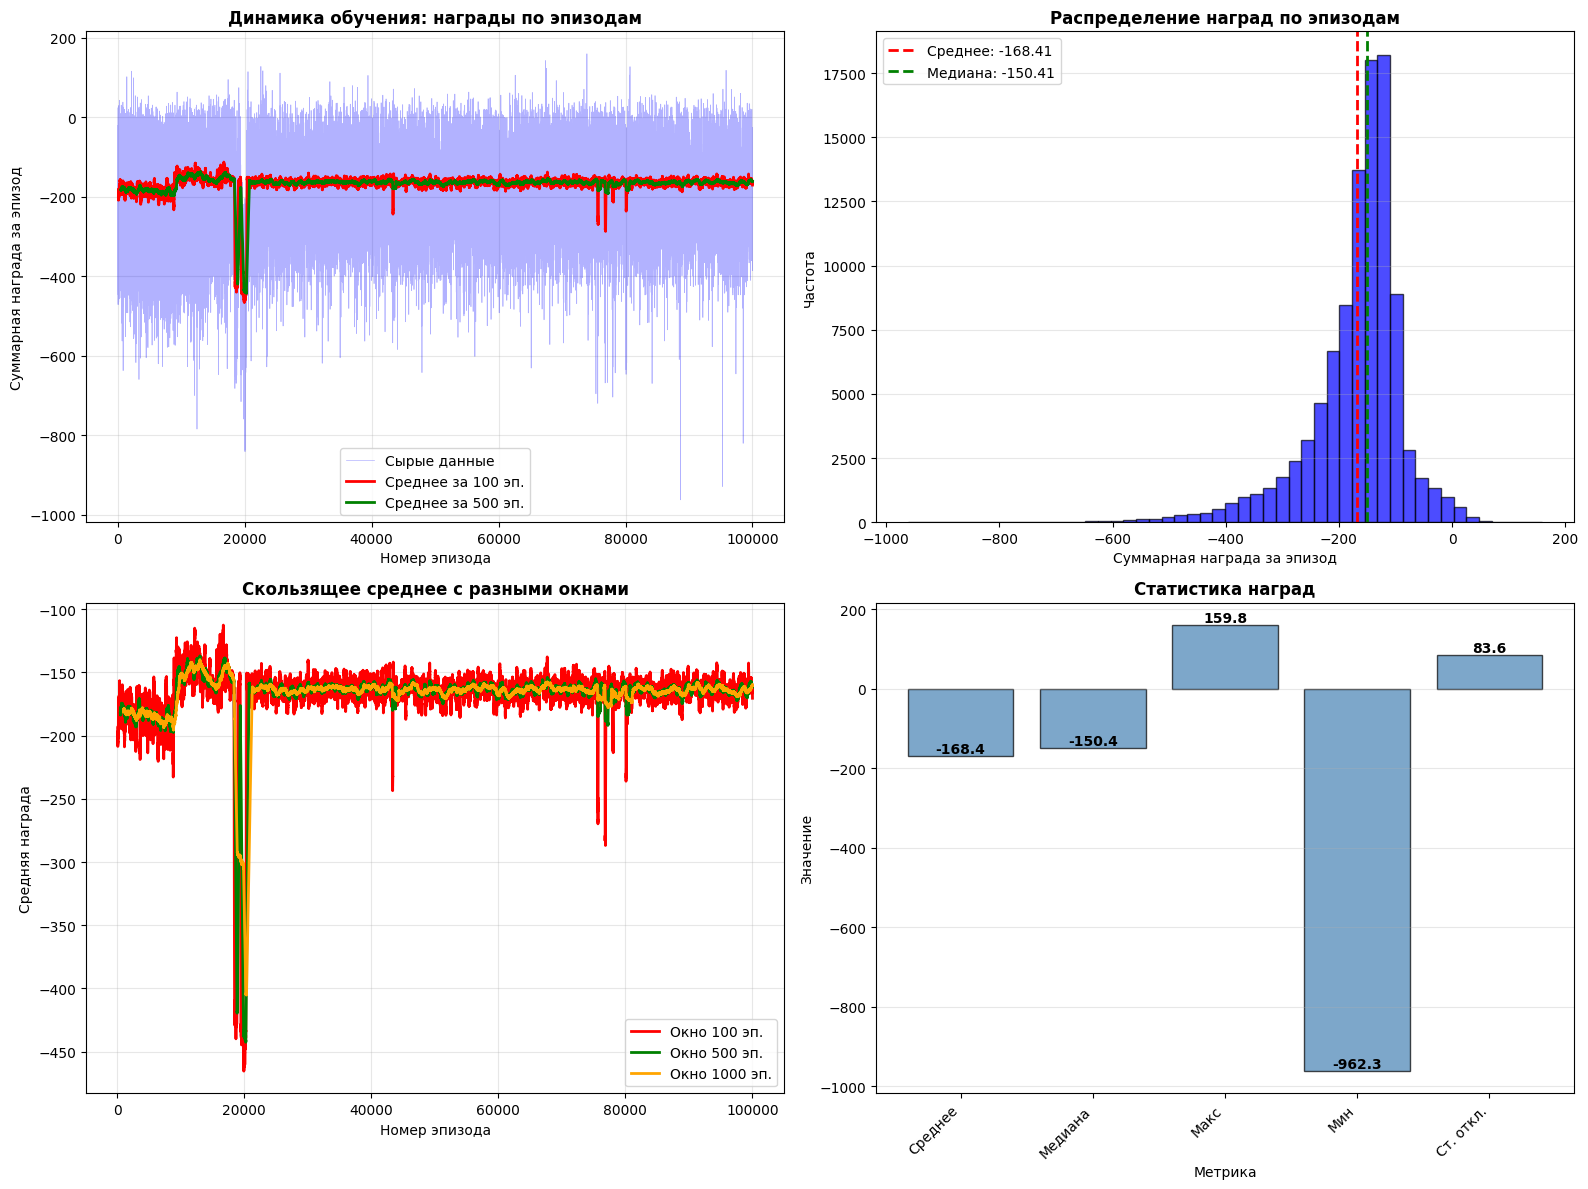

СТАТИСТИКА ОБУЧЕНИЯ
Минимальная награда: -962.33
Максимальная награда: 159.78
Средняя награда: -168.41
Медиана награды: -150.41
Стандартное отклонение: 83.61
Количество эпизодов: 100000

2. Статистика Q-функции:


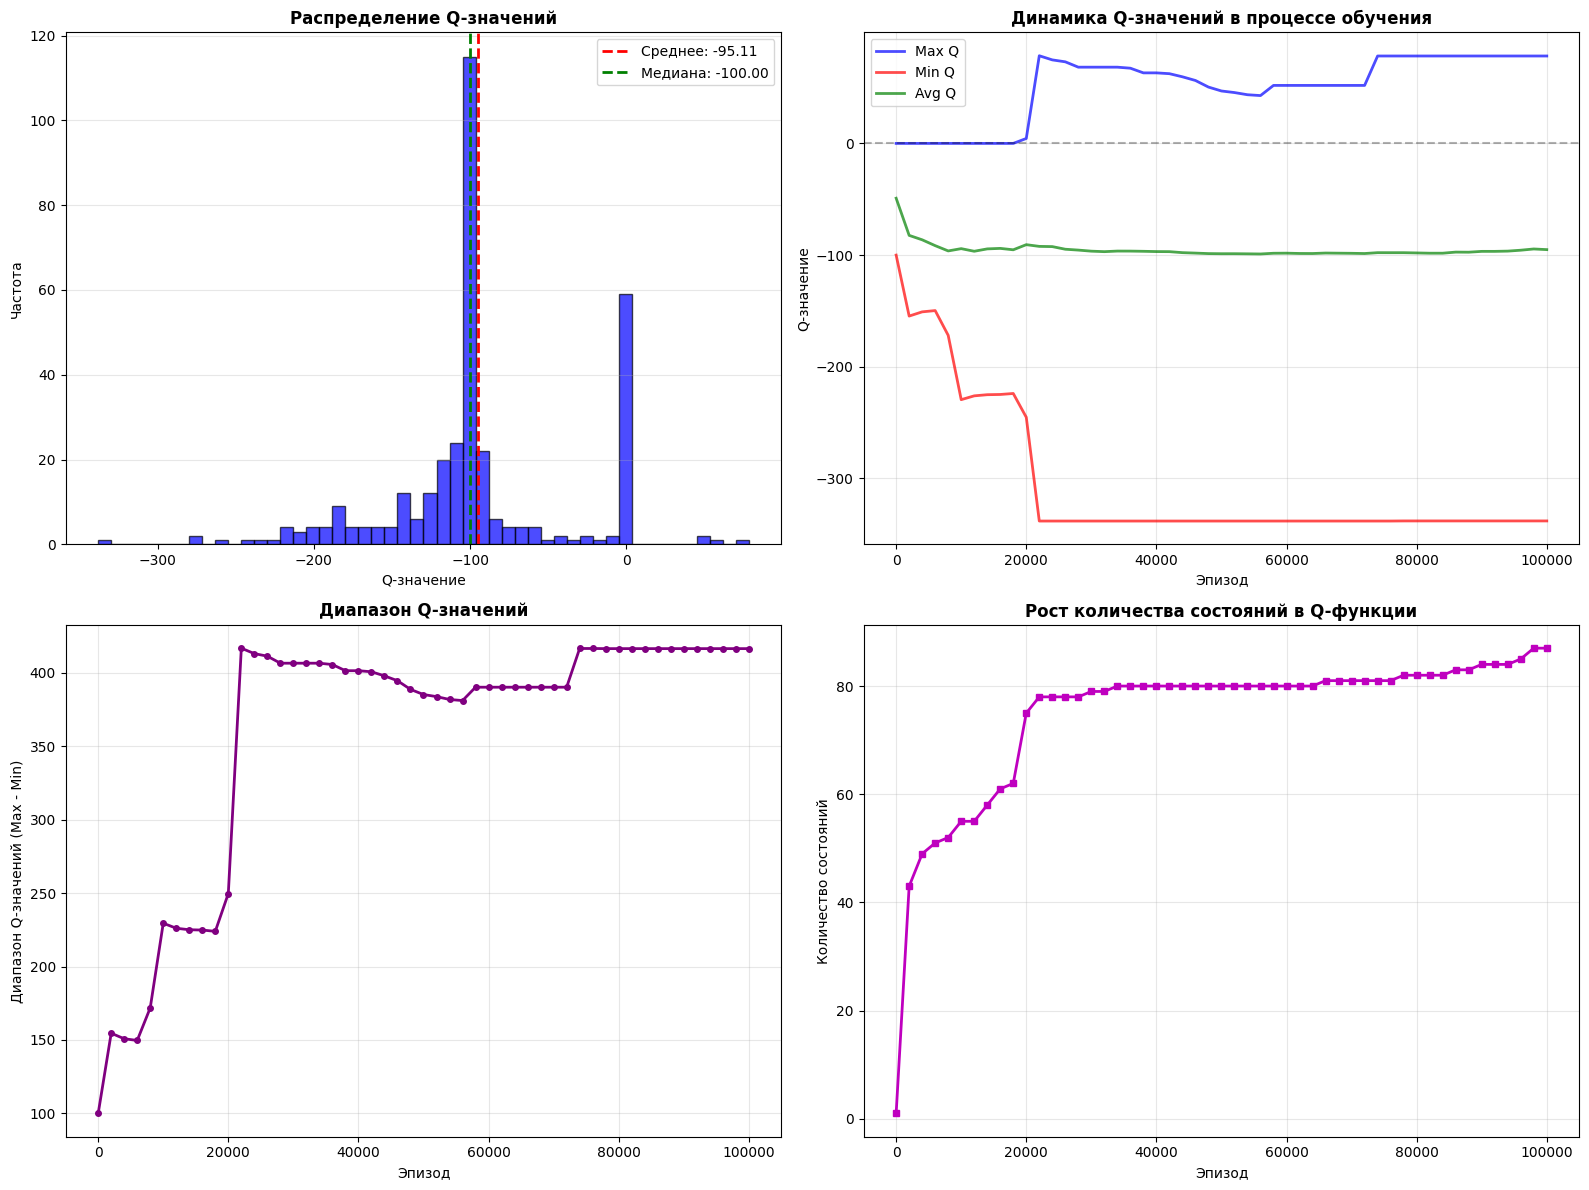

СТАТИСТИКА Q-ФУНКЦИИ
Количество состояний: 87
Среднее Q-значение: -95.1058
Медиана Q-значения: -100.0000
Максимальное Q-значение: 78.2723
Минимальное Q-значение: -338.0387
Стандартное отклонение: 60.6000

Динамика:
  Начальный диапазон: 100.00
  Финальный диапазон: 416.31
  Изменение диапазона: 316.31

3. Анализ стратегии:


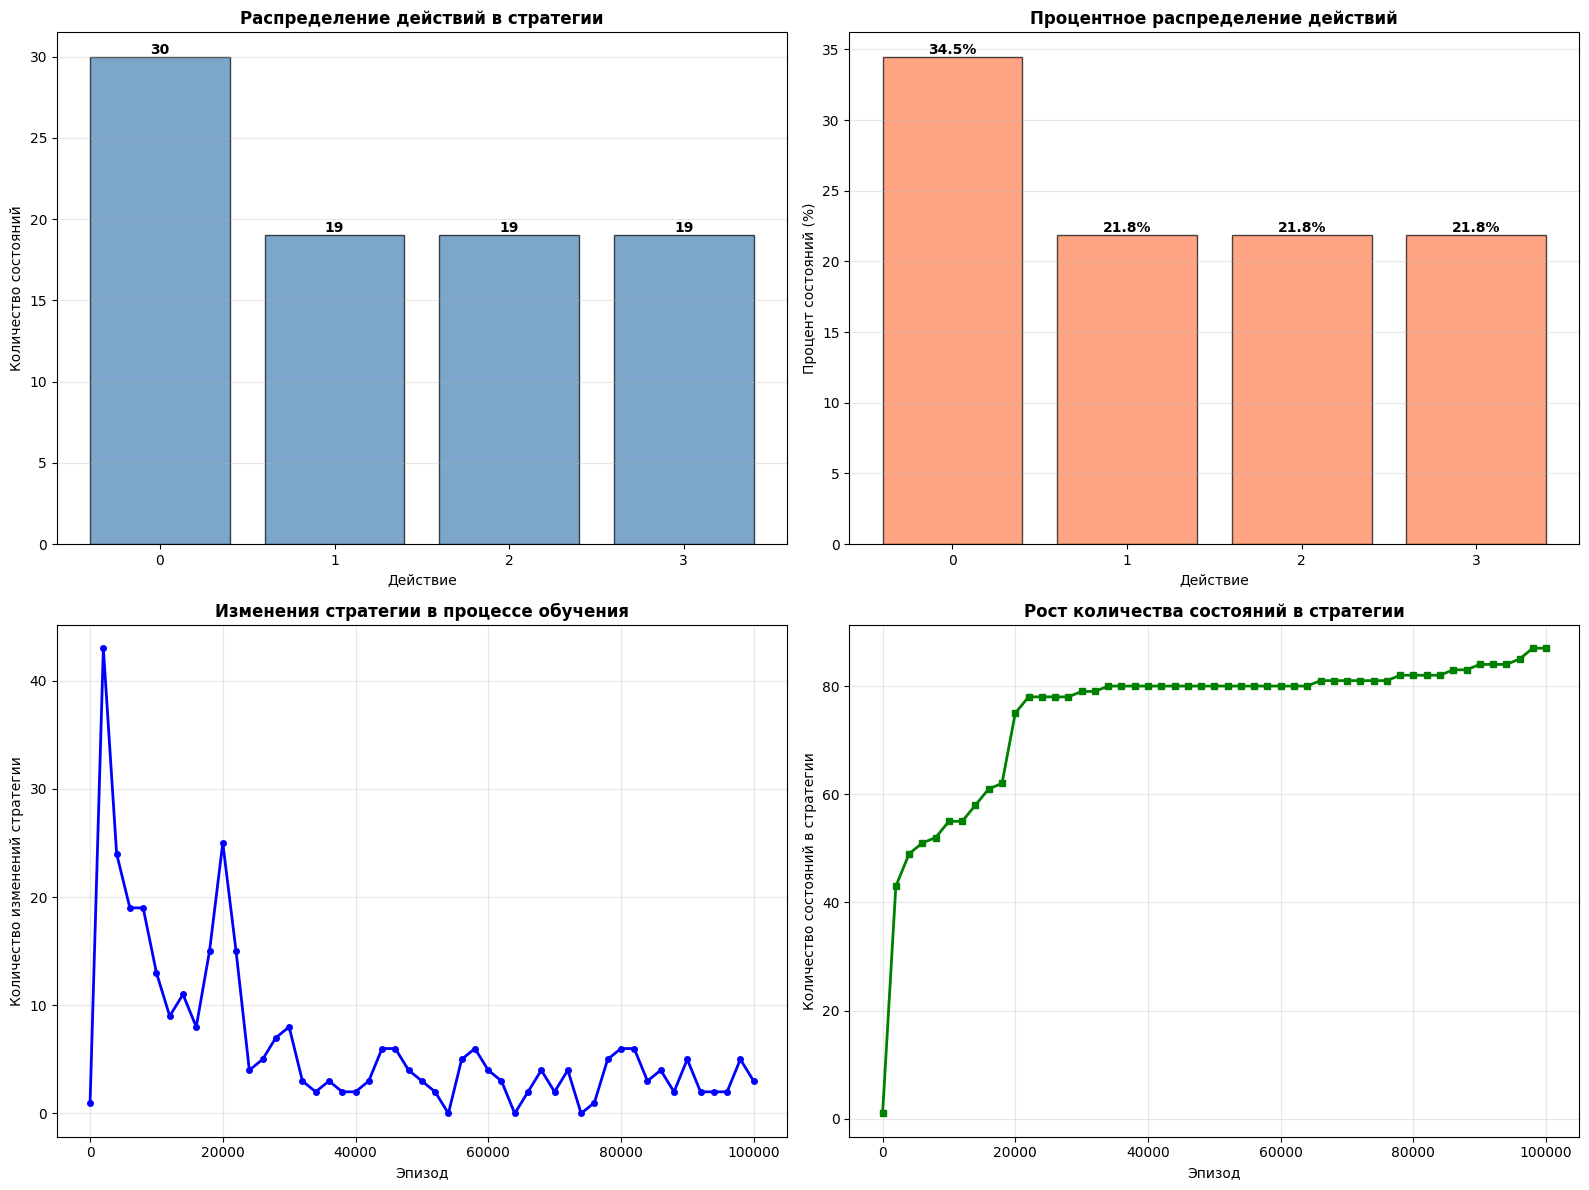

АНАЛИЗ СТРАТЕГИИ
Общее количество состояний в стратегии: 87

Распределение действий:
  Действие 0: 30 состояний (34.5%)
  Действие 1: 19 состояний (21.8%)
  Действие 2: 19 состояний (21.8%)
  Действие 3: 19 состояний (21.8%)

Изменения стратегии:
  Максимальное количество изменений за этап: 43
  Среднее количество изменений за этап: 6.63
  Общее количество изменений: 338

Рост стратегии:
  Начальное количество состояний: 1
  Финальное количество состояний: 87
  Рост: 86 состояний


In [9]:
#@title Функции визуализации результатов обучения

def plot_learning_curves(returns):
    """
    Визуализация кривых обучения.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. График наград по эпизодам (сырые данные + сглаженные)
    axes[0, 0].plot(returns, alpha=0.3, color='blue', label='Сырые данные', linewidth=0.5)

    # Сглаженные кривые (скользящее среднее)
    window = 100
    if len(returns) >= window:
        smoothed = np.convolve(returns, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(returns)), smoothed,
                       color='red', linewidth=2, label=f'Среднее за {window} эп.')

    window_large = 500
    if len(returns) >= window_large:
        smoothed_large = np.convolve(returns, np.ones(window_large)/window_large, mode='valid')
        axes[0, 0].plot(range(window_large-1, len(returns)), smoothed_large,
                       color='green', linewidth=2, label=f'Среднее за {window_large} эп.')

    axes[0, 0].set_xlabel('Номер эпизода')
    axes[0, 0].set_ylabel('Суммарная награда за эпизод')
    axes[0, 0].set_title('Динамика обучения: награды по эпизодам', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Распределение наград (гистограмма)
    axes[0, 1].hist(returns, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].axvline(np.mean(returns), color='r', linestyle='--', linewidth=2,
                       label=f'Среднее: {np.mean(returns):.2f}')
    axes[0, 1].axvline(np.median(returns), color='g', linestyle='--', linewidth=2,
                       label=f'Медиана: {np.median(returns):.2f}')
    axes[0, 1].set_xlabel('Суммарная награда за эпизод')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].set_title('Распределение наград по эпизодам', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # 3. Скользящее среднее по разным окнам
    windows = [100, 500, 1000]
    colors = ['red', 'green', 'orange']
    for window, color in zip(windows, colors):
        if len(returns) >= window:
            smoothed = np.convolve(returns, np.ones(window)/window, mode='valid')
            axes[1, 0].plot(range(window-1, len(returns)), smoothed,
                           color=color, linewidth=2, label=f'Окно {window} эп.')

    axes[1, 0].set_xlabel('Номер эпизода')
    axes[1, 0].set_ylabel('Средняя награда')
    axes[1, 0].set_title('Скользящее среднее с разными окнами', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Статистика по эпизодам
    stats_labels = ['Среднее', 'Медиана', 'Макс', 'Мин', 'Ст. откл.']
    stats_values = [np.mean(returns), np.median(returns),
                   np.max(returns), np.min(returns), np.std(returns)]

    x = np.arange(len(stats_labels))
    axes[1, 1].bar(x, stats_values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Метрика')
    axes[1, 1].set_ylabel('Значение')
    axes[1, 1].set_title('Статистика наград', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(stats_labels, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Добавление значений на столбцы
    for i, v in enumerate(stats_values):
        axes[1, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("=" * 60)
    print("СТАТИСТИКА ОБУЧЕНИЯ")
    print("=" * 60)
    print(f"Минимальная награда: {np.min(returns):.2f}")
    print(f"Максимальная награда: {np.max(returns):.2f}")
    print(f"Средняя награда: {np.mean(returns):.2f}")
    print(f"Медиана награды: {np.median(returns):.2f}")
    print(f"Стандартное отклонение: {np.std(returns):.2f}")
    print(f"Количество эпизодов: {len(returns)}")


def plot_q_function_stats(Q, q_history):
    """
    Визуализация статистики Q-функции.
    """
    # Сбор всех Q-значений
    q_values = []
    for state, q_vals in Q.items():
        q_values.extend([q.item() for q in q_vals])

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Распределение Q-значений
    axes[0, 0].hist(q_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(np.mean(q_values), color='r', linestyle='--', linewidth=2,
                      label=f'Среднее: {np.mean(q_values):.2f}')
    axes[0, 0].axvline(np.median(q_values), color='g', linestyle='--', linewidth=2,
                      label=f'Медиана: {np.median(q_values):.2f}')
    axes[0, 0].set_xlabel('Q-значение')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].set_title('Распределение Q-значений', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # 2. Динамика Q-значений в процессе обучения
    episodes = q_history['episodes']
    axes[0, 1].plot(episodes, q_history['max_q'], 'b-', linewidth=2, label='Max Q', alpha=0.7)
    axes[0, 1].plot(episodes, q_history['min_q'], 'r-', linewidth=2, label='Min Q', alpha=0.7)
    axes[0, 1].plot(episodes, q_history['avg_q'], 'g-', linewidth=2, label='Avg Q', alpha=0.7)
    axes[0, 1].set_xlabel('Эпизод')
    axes[0, 1].set_ylabel('Q-значение')
    axes[0, 1].set_title('Динамика Q-значений в процессе обучения', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)

    # 3. Диапазон Q-значений
    q_range = [max_q - min_q for max_q, min_q in zip(q_history['max_q'], q_history['min_q'])]
    axes[1, 0].plot(episodes, q_range, 'purple', linewidth=2, marker='o', markersize=4)
    axes[1, 0].set_xlabel('Эпизод')
    axes[1, 0].set_ylabel('Диапазон Q-значений (Max - Min)')
    axes[1, 0].set_title('Диапазон Q-значений', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Количество состояний в Q-функции
    axes[1, 1].plot(episodes, q_history['num_states'], 'm-', linewidth=2, marker='s', markersize=4)
    axes[1, 1].set_xlabel('Эпизод')
    axes[1, 1].set_ylabel('Количество состояний')
    axes[1, 1].set_title('Рост количества состояний в Q-функции', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("=" * 60)
    print("СТАТИСТИКА Q-ФУНКЦИИ")
    print("=" * 60)
    print(f"Количество состояний: {len(Q)}")
    print(f"Среднее Q-значение: {np.mean(q_values):.4f}")
    print(f"Медиана Q-значения: {np.median(q_values):.4f}")
    print(f"Максимальное Q-значение: {np.max(q_values):.4f}")
    print(f"Минимальное Q-значение: {np.min(q_values):.4f}")
    print(f"Стандартное отклонение: {np.std(q_values):.4f}")
    print(f"\nДинамика:")
    print(f"  Начальный диапазон: {q_range[0]:.2f}")
    print(f"  Финальный диапазон: {q_range[-1]:.2f}")
    print(f"  Изменение диапазона: {q_range[-1] - q_range[0]:.2f}")


def plot_policy_analysis(policy, policy_history):
    """
    Визуализация анализа стратегии.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Распределение действий в стратегии
    action_counts = {i: 0 for i in range(N_ACTION)}
    for state, action in policy.items():
        action_counts[action] += 1

    actions = list(range(N_ACTION))
    counts = [action_counts[i] for i in actions]

    axes[0, 0].bar(actions, counts, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Действие')
    axes[0, 0].set_ylabel('Количество состояний')
    axes[0, 0].set_title('Распределение действий в стратегии', fontweight='bold')
    axes[0, 0].set_xticks(actions)
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Добавление значений на столбцы
    for i, count in enumerate(counts):
        if count > 0:
            axes[0, 0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

    # 2. Процентное распределение действий
    total = sum(counts) if sum(counts) > 0 else 1
    percents = [100 * c / total for c in counts]

    axes[0, 1].bar(actions, percents, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Действие')
    axes[0, 1].set_ylabel('Процент состояний (%)')
    axes[0, 1].set_title('Процентное распределение действий', fontweight='bold')
    axes[0, 1].set_xticks(actions)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Добавление значений на столбцы
    for i, pct in enumerate(percents):
        if pct > 0:
            axes[0, 1].text(i, pct, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 3. Изменения стратегии в процессе обучения
    episodes_policy = policy_history['episodes']
    axes[1, 0].plot(episodes_policy, policy_history['policy_changes'],
                   'b-', linewidth=2, marker='o', markersize=4)
    axes[1, 0].set_xlabel('Эпизод')
    axes[1, 0].set_ylabel('Количество изменений стратегии')
    axes[1, 0].set_title('Изменения стратегии в процессе обучения', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Рост количества состояний в стратегии
    axes[1, 1].plot(episodes_policy, policy_history['num_states'],
                   'g-', linewidth=2, marker='s', markersize=4)
    axes[1, 1].set_xlabel('Эпизод')
    axes[1, 1].set_ylabel('Количество состояний в стратегии')
    axes[1, 1].set_title('Рост количества состояний в стратегии', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("=" * 60)
    print("АНАЛИЗ СТРАТЕГИИ")
    print("=" * 60)
    print(f"Общее количество состояний в стратегии: {len(policy)}")
    print(f"\nРаспределение действий:")
    for action, count in enumerate(counts):
        print(f"  Действие {action}: {count} состояний ({percents[action]:.1f}%)")
    print(f"\nИзменения стратегии:")
    print(f"  Максимальное количество изменений за этап: {max(policy_history['policy_changes'])}")
    print(f"  Среднее количество изменений за этап: {np.mean(policy_history['policy_changes']):.2f}")
    print(f"  Общее количество изменений: {sum(policy_history['policy_changes'])}")
    print(f"\nРост стратегии:")
    print(f"  Начальное количество состояний: {policy_history['num_states'][0]}")
    print(f"  Финальное количество состояний: {policy_history['num_states'][-1]}")
    print(f"  Рост: {policy_history['num_states'][-1] - policy_history['num_states'][0]} состояний")


# Выполнение визуализации
print("=" * 60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
print("=" * 60)

print("\n1. Кривые обучения:")
plot_learning_curves(returns)

print("\n2. Статистика Q-функции:")
plot_q_function_stats(Q_optimal, q_history)

print("\n3. Анализ стратегии:")
plot_policy_analysis(optimal_policy, policy_history)

# Выводы по проделанной работе

В рамках данной работы мной была реализована система обучения с подкреплением для среды LunarLander с использованием off-policy метода Монте-Карло с разделенной стратегией. Я использовал алгоритм Weighted Importance Sampling для обучения целевой политики на данных, собранных ε-soft поведенческой политикой. Для работы с непрерывным пространством состояний мной была реализована функция дискретизации, которая преобразует 8-мерное непрерывное пространство состояний в дискретное представление с использованием бинирования.

При реализации off-policy метода я использовал детерминированно жадную целевую политику, которая всегда выбирает действие с максимальным Q-значением, что соответствует классическому подходу из лекции. Мной была использована ε-soft поведенческая стратегия с линейным затуханием epsilon от 0.9 до 0.1, что обеспечивает баланс между исследованием и эксплуатацией в процессе обучения. Для вычисления importance sampling весов я применял формулу w *= 1.0 / b_prob без дополнительных условий и клиппинга, следуя классическому алгоритму.

Для анализа динамики обучения мной была реализована система отслеживания изменений Q-функции и стратегии: я сохранял историю максимальных, минимальных и средних Q-значений, а также количество изменений стратегии на регулярных интервалах. Это позволило визуализировать эволюцию обучения с помощью графиков, показывающих изменения метрик Q-функции, динамику изменений стратегии и связь между этими процессами.

Для обучения мной были установлены параметры: коэффициент обесценивания gamma равен 0.99 для учета долгосрочных наград, количество эпизодов обучения составляет 100000. Я использовал библиотеку PyTorch для эффективных вычислений с тензорами и defaultdict для хранения Q-функции в разреженном формате, что критически важно для работы с большим пространством состояний.

По результатам экспериментов мной было установлено, что модель демонстрирует ограниченную способность к обучению в данной среде. Анализ показывает несколько причин, почему модель не учится эффективно: во-первых, грубая дискретизация 8-мерного пространства состояний приводит к потере важной информации о непрерывных параметрах движения, что критично для точного управления космическим аппаратом. Во-вторых, off-policy метод Монте-Карло с importance sampling страдает от высокой дисперсии весов, особенно при большом расхождении между поведенческой и целевой политиками, что замедляет сходимость. В-третьих, среда LunarLander является сложной задачей с длинными эпизодами и редкими наградами, требующей значительного количества взаимодействий для эффективного обучения, а 30000 эпизодов может быть недостаточно для такой сложной среды. В-четвертых, tabular методы Монте-Карло плохо масштабируются на большие пространства состояний, и даже при дискретизации количество возможных состояний остается очень большим, что приводит к недостаточному покрытию пространства состояний. Наконец, отсутствие клиппинга importance sampling весов может приводить к численной нестабильности при больших значениях весов, что негативно влияет на обучение. Для улучшения результатов потребовались бы более продвинутые методы, такие как deep Q-learning или policy gradient методы, которые лучше подходят для сложных непрерывных сред.